In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt
import warnings

from data_preparation_tools import preprocessing_data
from common_tools import plot_roc_auc, save_model_and_results
from cv_wrappers_and_tools_XGB import cv_xgb, make_prediction_xgb

warnings.filterwarnings("ignore", category=UserWarning)
xgb.set_config(verbosity = 0)

/home/michail/DS/anaconda3/envs/Suspicious_network_event_recognition/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# XGBoost

## Grid search

In [3]:
df_train = pd.read_csv('input/cybersecurity_training.csv', sep='|', index_col=0)
df_test = pd.read_csv('input/cybersecurity_test.csv', sep='|', index_col=0)
print(df_train.shape)
print(df_test.shape)

(39427, 62)
(20000, 61)


In [4]:
# Select features, that won't be used to create predictive models
feature_black_list = ['grandparent_category', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'score']
# Select target variable
target = 'notified'
# Prepare  training and test datasets for modeling
preprocessed_train_df, preprocessed_test_df, _, features = preprocessing_data(df_train, df_test, target, feature_black_list)

In [ ]:
trainResults, testResults, predictions, indices, hists = cv_xgb(preprocessed_train_df, target, features, debug=True, mlflow_tracking=True)
print(f'Train mean: {np.mean(trainResults)}, Valid mean: {np.mean(testResults)}')

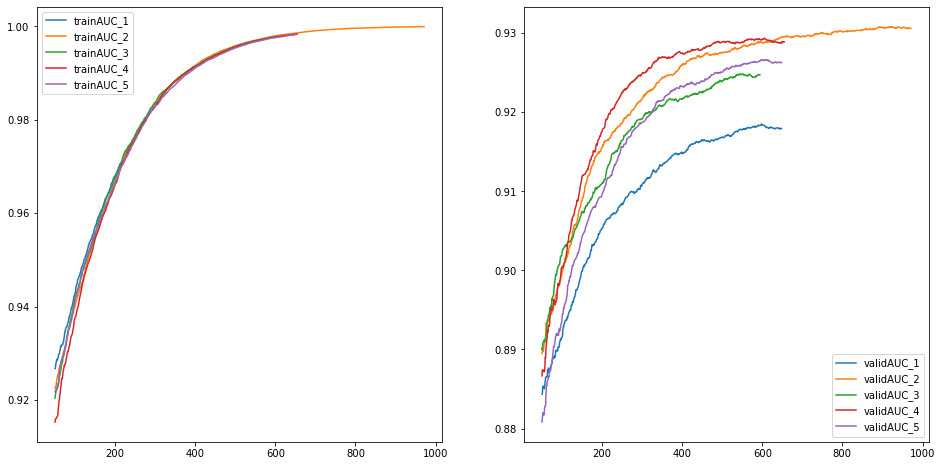

In [14]:
# Plot to compare results of each train and validation fold after using Cross Validation
fig, ax = plt.subplots(1, 2, figsize=(16,8))
for x in range(1, 6):
    hists[['trainAUC'+'_'+str(x)]].iloc[50:].plot(ax=ax[0])
    hists[['validAUC'+'_'+str(x)]].iloc[50:].plot(ax=ax[1])
plt.show()

19 0.9326597589305943
20 0.9330307559007067
21 0.9330814475581672
22 0.9332617308510356
23 0.9332684832994902
24 0.9328623218424033


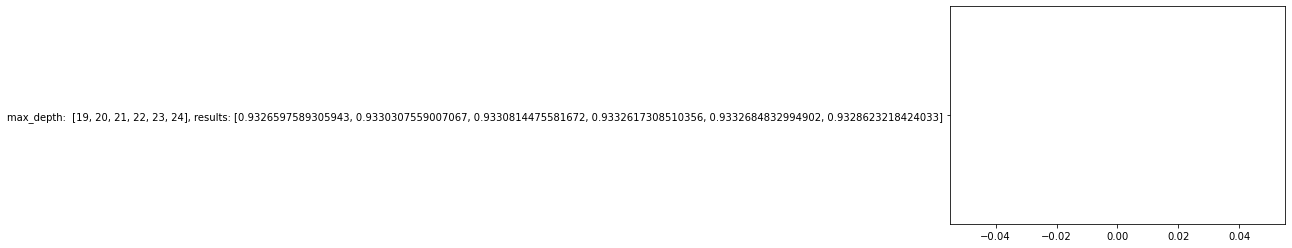

In [35]:
# Trying to find the best hyperparameters using Grid Search
rang = range(19,25)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = cv_xgb(preprocessed_train_df, target, features, debug=False, mlflow_tracking=True, max_depth=x)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))

plt.plot(list(rang), results)
plt.show()

2 0.917760048552943
3 0.9226174383756136
4 0.9267803984610437
5 0.9296506808961553
6 0.9316355971539172
7 0.9332617308510356
8 0.9346881834065606
9 0.9354792630325551


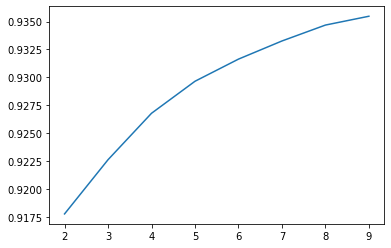

In [36]:
rang = range(2,10)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = cv_xgb(preprocessed_train_df, target, features, debug=False, mlflow_tracking=True,
        max_depth=22, subsample = x/10)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))

plt.plot(list(rang), results)
plt.show()

2 0.9313525175175672
3 0.9339277115487968
4 0.9353701765010494
5 0.9359784272469975
6 0.9349333648650869
7 0.9347080167292269
8 0.9342428748236715
9 0.9333429773385555


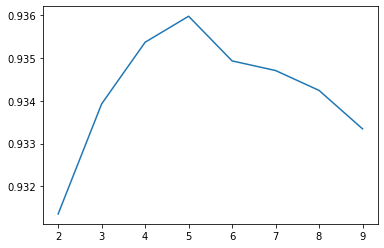

In [37]:
rang = range(2,10)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = cv_xgb(preprocessed_train_df, target, features, debug=False, mlflow_tracking=True,
        max_depth=23, subsample = 0.8, colsample_bytree = x/10)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))

plt.plot(list(rang), results)
plt.show()

In [ ]:
rang = range(0,8)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = cv_xgb(preprocessed_train_df, target, features, debug=False, mlflow_tracking=True,
        max_depth=23, subsample = 0.8, colsample_bytree = 0.5, lambdaX=x**2)
    print(x**2, np.mean(testResults))
    results.append(np.mean(testResults))

plt.plot(list(rang), results)
plt.show()

In [ ]:
params = {
    'max_depth': 23,
    'subsample': 0.8,
    'colsample_bytree': 0.5,
    'lambdaX': 1
}
trainResults, testResults, predictions, indices, hists = cv_xgb(preprocessed_train_df, target, features, debug=True, mlflow_tracking=True, exp_name="exp_3_XGBoost" , **params)
print(f'Train mean: {np.mean(trainResults)}, Test mean: {np.mean(testResults)}')

In [39]:
rang = [0.01, 0.1, 0.5, 1, 2, 4, 6, 8, 10, 15]
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = cv_xgb(preprocessed_train_df, target, features, debug=False, mlflow_tracking=True,
        max_depth=23, subsample = 0.8, colsample_bytree = 0.5, lambdaX=1, gamma=x)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))

plt.plot(list(rang), results)
plt.show()

0.01 0.9356847168551689
0.1 0.9353868781633305
0.5 0.9346298607081603
1 0.9341392570807052


KeyboardInterrupt: 

In [ ]:
# Save results to file
modelXGB= {
    "name":"XGB-1",
    "description":"Model XGB, ze zmiennymi kategorycznymi",
    "specification": params,
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
    'features':features
}
save_model_and_results('model_xgb_1', modelXGB)

### Let's try improve our model after feature preprocessing

In [2]:
df_train = pd.read_csv('input/cybersecurity_training.csv', sep='|', index_col=0)
df_test = pd.read_csv('input/cybersecurity_test.csv', sep='|', index_col=0)

# Set number of main categories in each categorical variable.
categorical_features = [
    ("categoryname", 7),
    ("ipcategory_name", 5),
    ("ipcategory_scope", 2),
    ("dstipcategory_dominate", 4),
    ("srcipcategory_dominate", 4)
]

numeric_categorical_features = [
    ("parent_category", 2),
    ("overallseverity", 3),
    ("alerttype_cd", 3),
    ("direction_cd", 2),
    ("eventname_cd", 4),
    ("severity_cd", 3),
    ("devicetype_cd", 2),
    ("devicevendor_cd", 2),
    ("srcipcategory_cd", 3),
    ("dstipcategory_cd", 2),
    ("trustscore", 2),
    ("dstportcategory_dominate", 3),
    ("username_cd", 8),
    ("protocol_cd", 4),
    ("reportingdevice_cd", 5),
    ("dstport_cd", 5),
    ("srcport_cd", 10),
    ("dstip_cd", 6),
    ("srcip_cd", 10),
    ("p6", 3),
    ("p9", 1),
    ("p5m", 3),
    ("p5w", 2),
    ("p5d", 2),
    ("p8w", 2),
    ("p8m", 3),
    ("p8d", 2)
]
# Select numeric continue feature for normalisation.
numeric_continue_features = ["thrcnt_month", "thrcnt_week", "thrcnt_day", "timestamp_dist", "correlatedcount"]
# Black list with variables, that won't be used for making predictions
feature_black_list = ['grandparent_category', 'n10', 'n2', 'n7']
need_to_preproc = "ip"
# Manually selected variable for One Hot Encoding
one_hot_encoding = ["weekday"]
# Dictionary with types of variables and variables, tha will be used for data preprocessing.
features_for_preprocessing = {
    "categorical_features": categorical_features,
    "numeric_categorical_features": numeric_categorical_features,
    # "numeric_continue_features": numeric_continue_features,
    "feature_black_list": feature_black_list,
    "one_hot_encoding": one_hot_encoding
}

# Select target variable
target = 'notified'

0.001 0.9210185605231065
0.005 0.934860494747765
0.01 0.9370187007174859
0.02 0.9373517108602651
0.03 0.937110368110962
0.05 0.9362364719331936
0.08 0.9347688635408943
0.1 0.9352577547511368
0.2 0.930845797002565
0.5 0.9255444646118125
0.7 0.921666998533699


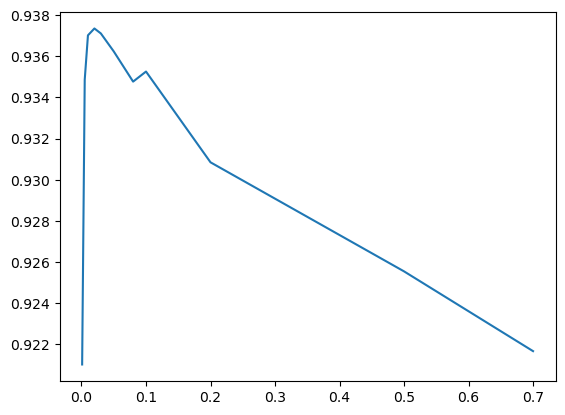

In [7]:
params = {
    'subsample': 0.9,
    'colsample_bytree': 0.5,
    'lambdax': 1,
    'max_depth':24,
    'early_stopping_rounds': 100,

}
preprocessed_train_df, preproc_test_df, features, _ =  preprocessing_data(df_train, df_test, target, features_for_preprocessing)
rang = [0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.2, 0.5, 0.7]
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = cv_xgb(preprocessed_train_df, target, features, debug=False, mlflow_tracking=True, exp_name="exp_4_feature_eng", eta = x,
                                                                    **params)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))

plt.plot(list(rang), results)
plt.show()

0.01 0.9370187007174859
0.015 0.9373726299825822
0.02 0.9373517108602651
0.025 0.9378251733424735
0.03 0.937110368110962
0.035 0.9370337173631093


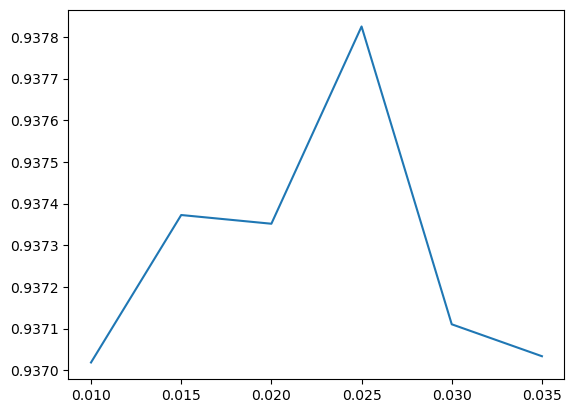

In [8]:
params = {
    'subsample': 0.9,
    'colsample_bytree': 0.5,
    'lambdax': 1,
    'max_depth':24,
    'early_stopping_rounds': 100,

}
preprocessed_train_df, preproc_test_df, features, _ =  preprocessing_data(df_train, df_test, target, features_for_preprocessing)
rang = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035]
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = cv_xgb(preprocessed_train_df, target, features, debug=False, mlflow_tracking=True, exp_name="exp_4_feature_eng", eta = x,
                                                                    **params)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))

plt.plot(list(rang), results)
plt.show()

## Random Search

In [7]:
df_train = pd.read_csv('input/cybersecurity_training.csv', sep='|', index_col=0)
df_test = pd.read_csv('input/cybersecurity_test.csv', sep='|', index_col=0)

# Set number of main categories in each categorical variable.
categorical_features = [
    ("categoryname", 7),
    ("ipcategory_name", 5),
    ("ipcategory_scope", 2),
    ("dstipcategory_dominate", 4),
    ("srcipcategory_dominate", 4)
]

numeric_categorical_features = [
    ("parent_category", 2),
    ("overallseverity", 3),
    ("alerttype_cd", 3),
    ("direction_cd", 2),
    ("eventname_cd", 4),
    ("severity_cd", 3),
    ("devicetype_cd", 2),
    ("devicevendor_cd", 2),
    ("srcipcategory_cd", 3),
    ("dstipcategory_cd", 2),
    ("trustscore", 2),
    ("dstportcategory_dominate", 3),
    ("username_cd", 8),
    ("protocol_cd", 4),
    ("reportingdevice_cd", 5),
    ("dstport_cd", 5),
    ("srcport_cd", 10),
    ("dstip_cd", 6),
    ("srcip_cd", 10),
    ("p6", 3),
    ("p9", 1),
    ("p5m", 3),
    ("p5w", 2),
    ("p5d", 2),
    ("p8w", 2),
    ("p8m", 3),
    ("p8d", 2)
]
# Select numeric continue feature for normalisation.
numeric_continue_features = ["thrcnt_month", "thrcnt_week", "thrcnt_day", "timestamp_dist"]
# Black list with variables, that won't be used for making predictions
feature_black_list = ['grandparent_category']
need_to_preproc = "ip"
# Manually selected variable for One Hot Encoding
one_hot_encoding = ["weekday"]
# Dictionary with types of variables and variables, tha will be used for data preprocessing.
features_for_preprocessing = {
    "categorical_features": categorical_features,
    "numeric_categorical_features": numeric_categorical_features,
    # "numeric_continue_features": numeric_continue_features,
    "feature_black_list": feature_black_list,
    "one_hot_encoding": one_hot_encoding
}

# Select target variable
target = 'notified'

In [9]:
# Data preprocessing
preprocessed_train_df, preproc_test_df, features, _ =  preprocessing_data(df_train, df_test, target, features_for_preprocessing)
# Trying to find the best hyperparameters using Random Search
import random
results=[]
paramList = []
for x in range(90):
    params = (random.randint(15, 30), random.uniform(0.3, 0.9), random.uniform(0.3, 0.7), random.uniform(0.1, 10), random.uniform(0, 5))
    trainResults, testResults, predictions, indices, hists = cv_xgb(preprocessed_train_df, target, features,
                                                                    mlflow_tracking=True,
                                                                    exp_name="exp_4_feature_eng",
                                                                    max_depth = params[0],
                                                                    subsample = params[1],
                                                                    colsample_bytree = params[2],
                                                                    lambdax=params[3]**2,
                                                                    gamma=params[4])
    print(np.mean(testResults), params)
    paramList.append(params)
    # Saving results
    results.append((np.mean(testResults), params.copy()))

    # Display results of current iteration
    print(params, np.mean(testResults))

    # Every 10 iterations display top 3 results from all iterations
    if x>1 and x%10==0:
        print("\n Top 3:")
        for score, params in sorted(results, key=lambda x: x[0], reverse=True)[0:3]:
            print(params, score)
        print()

TypeError: run_xgb() got an unexpected keyword argument 'lambdaX'

In [ ]:
# Plot the top 10 higher-scoring experiments and their hyperparameters.
maxRes = []
for i in range(1, len(paramList)):
    maxRes.append(max(results[0:i]))
imp = list(zip(results, paramList))
imp.sort(reverse=True)
for row in imp[0:10]:
    print(row)

In [ ]:
# Plot to check how many iterations in RS we need to find better score and parameters
plt.plot(list(range(len(results)-1)), maxRes)
plt.show()

eta 0.025, max_depth 24, subsample 0.9, colsample_bytree 0.5, colsample_bylevel 1, lambdax 1, alpha 0, gamma 0, min_child_weight 0, num_boost_round 1000, early_stopping_rounds 100, rate_drop 0.2, skip_drop 0.5, eval_metric ['auc'], objective binary:logistic, seed 2022, booster gbtree, tree_method exact, grow_policy depthwise, 
Length train: 31541
Length valid: 7886
[0]	train-auc:0.90117	valid-auc:0.83109
[10]	train-auc:0.97102	valid-auc:0.87978
[20]	train-auc:0.97844	valid-auc:0.89471
[30]	train-auc:0.98378	valid-auc:0.90137
[40]	train-auc:0.98784	valid-auc:0.90944
[50]	train-auc:0.98936	valid-auc:0.91134
[60]	train-auc:0.99145	valid-auc:0.91396
[70]	train-auc:0.99245	valid-auc:0.91591
[80]	train-auc:0.99301	valid-auc:0.91631
[90]	train-auc:0.99422	valid-auc:0.91719
[100]	train-auc:0.99546	valid-auc:0.91779
[110]	train-auc:0.99737	valid-auc:0.92054
[120]	train-auc:0.99872	valid-auc:0.92180
[130]	train-auc:0.99920	valid-auc:0.92313
[140]	train-auc:0.99939	valid-auc:0.92395
[150]	train-a

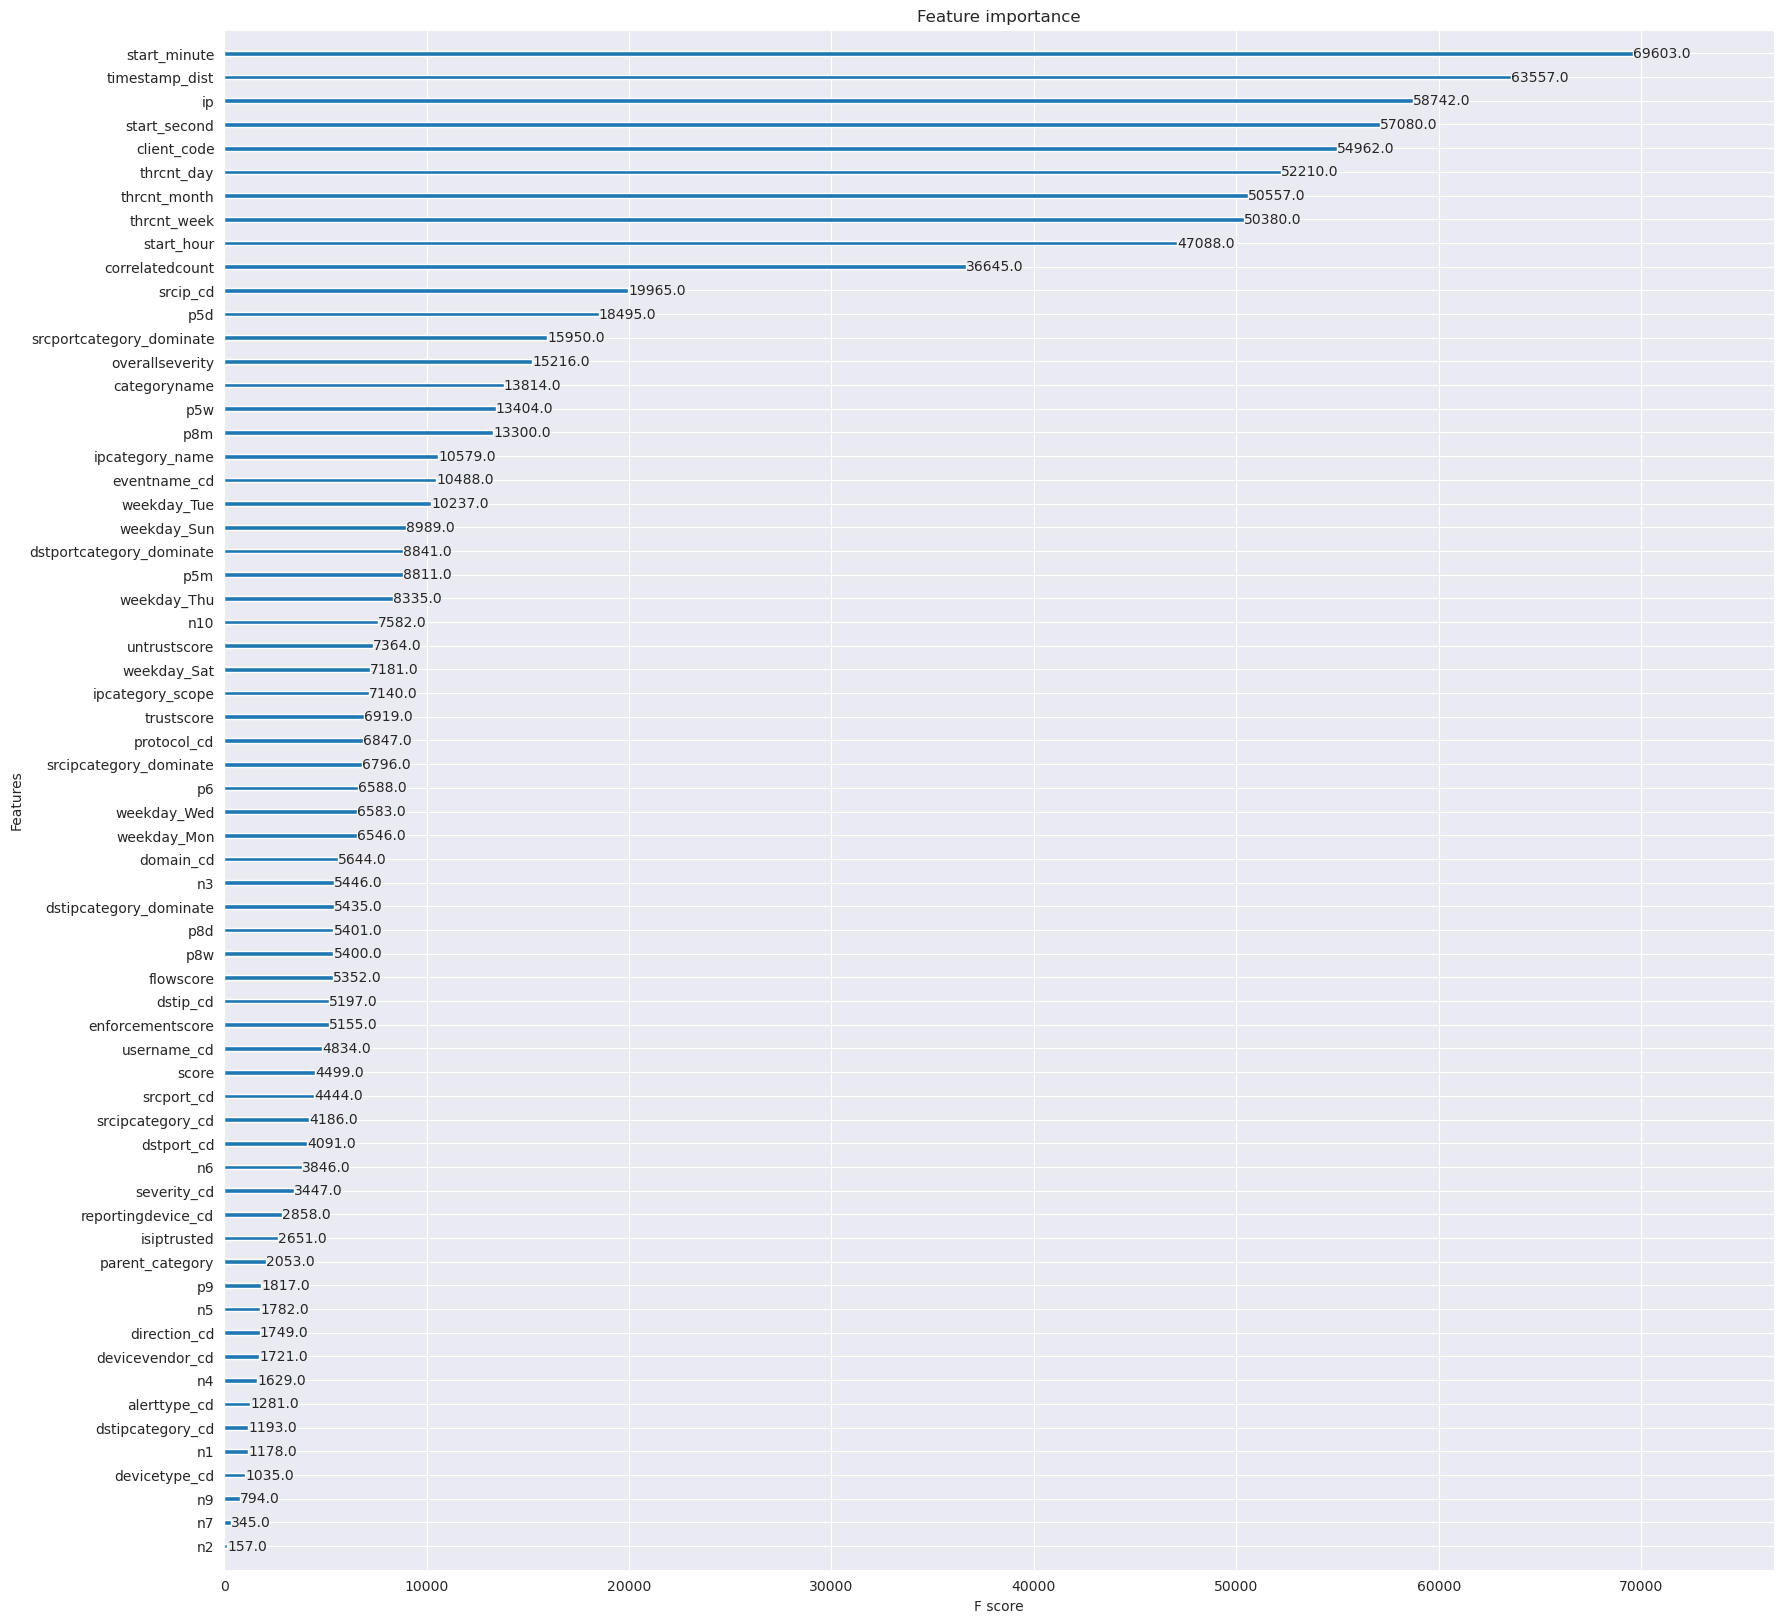

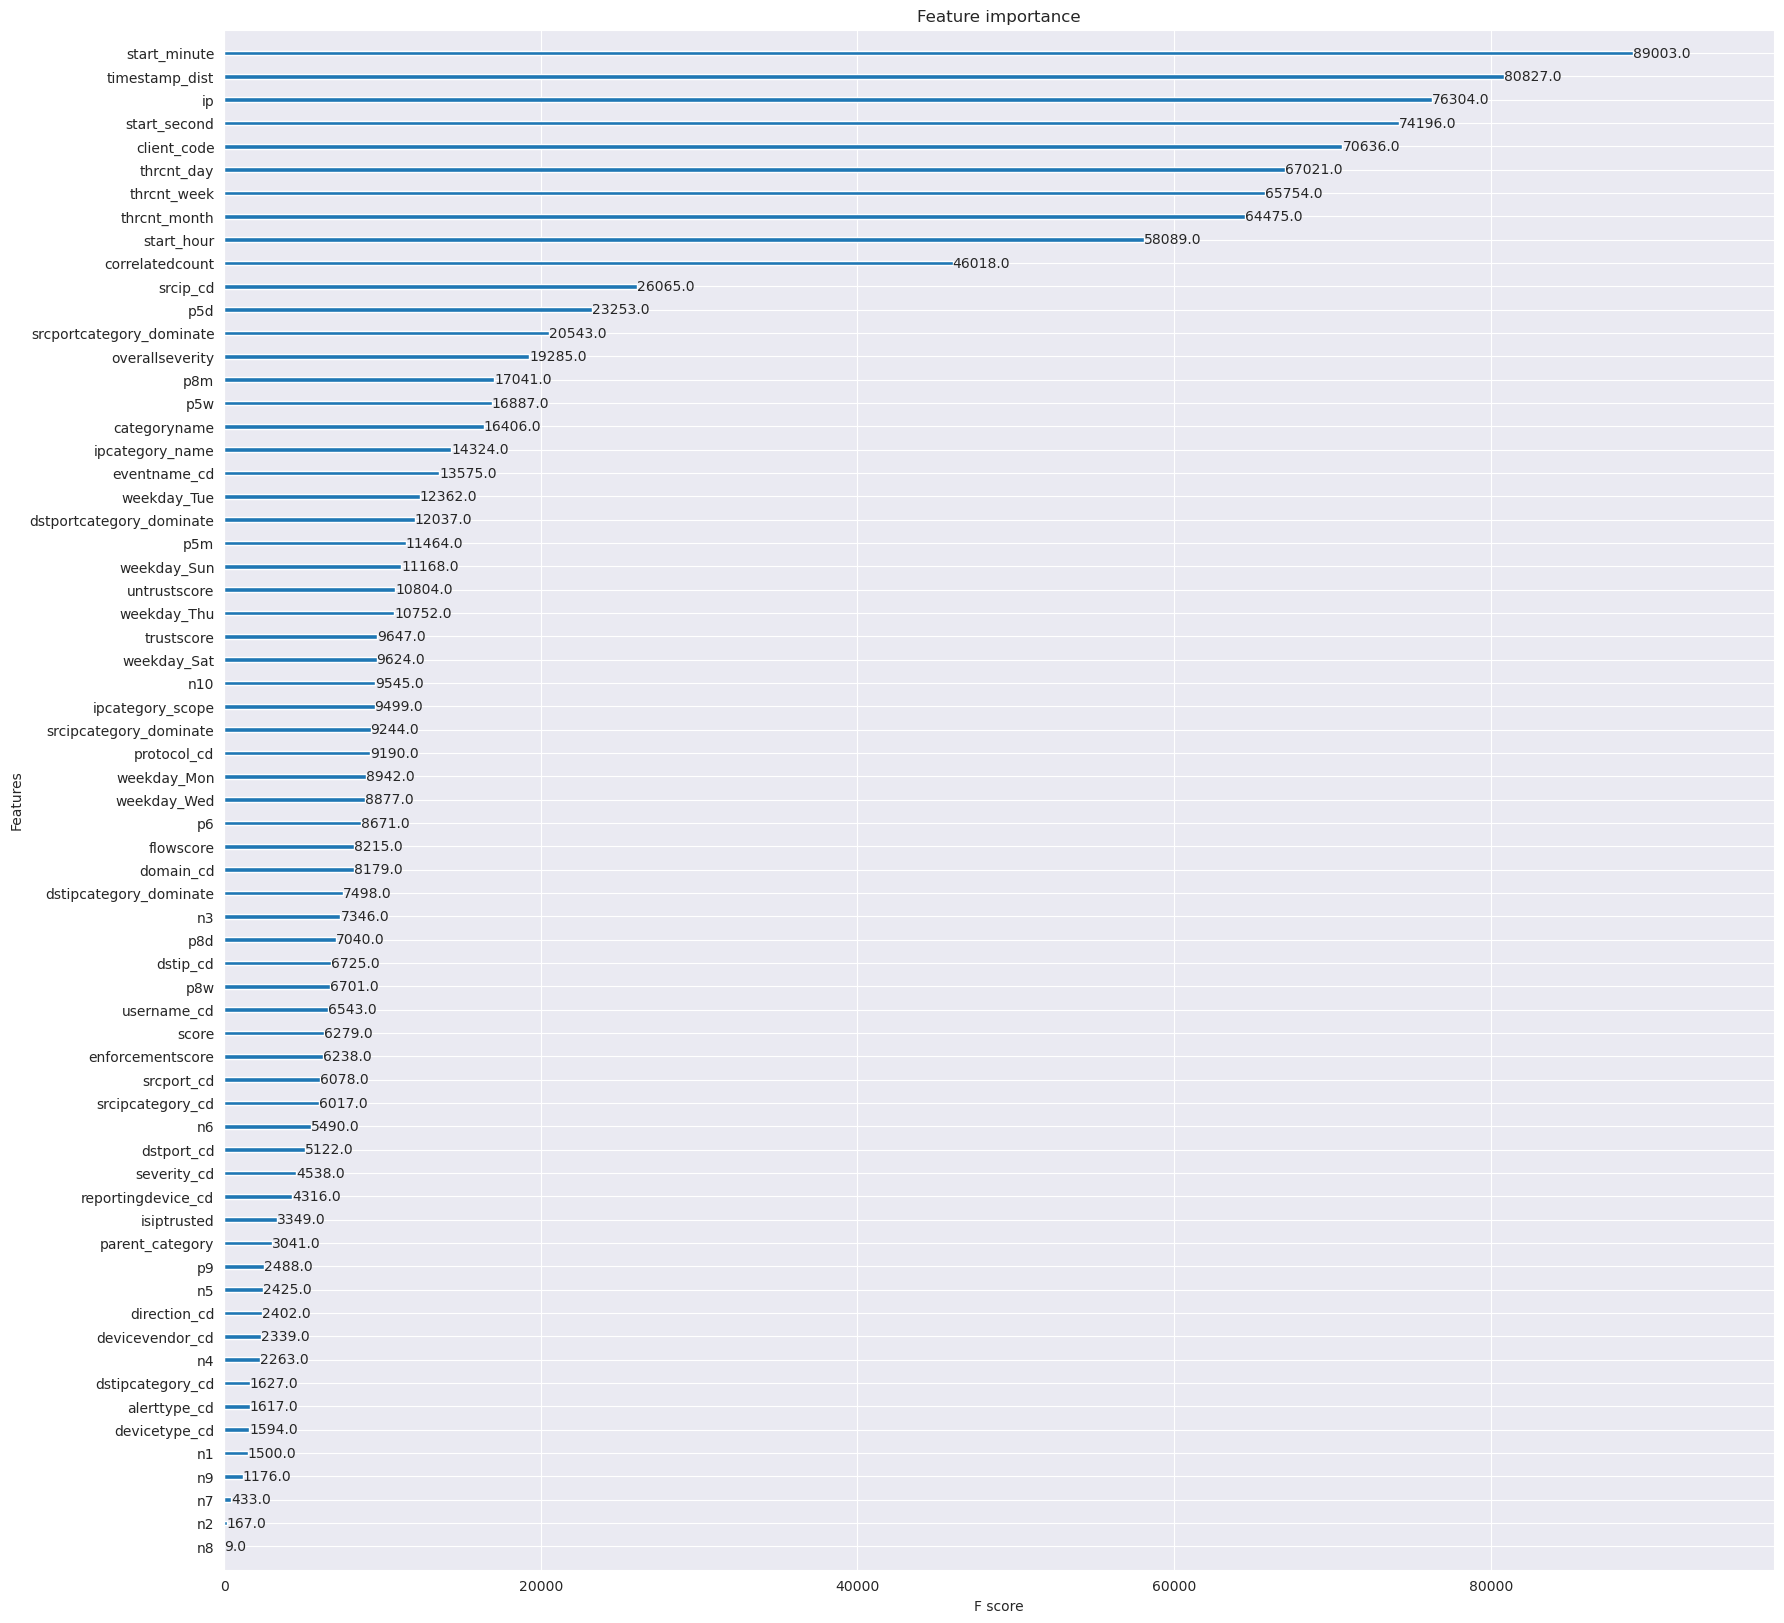

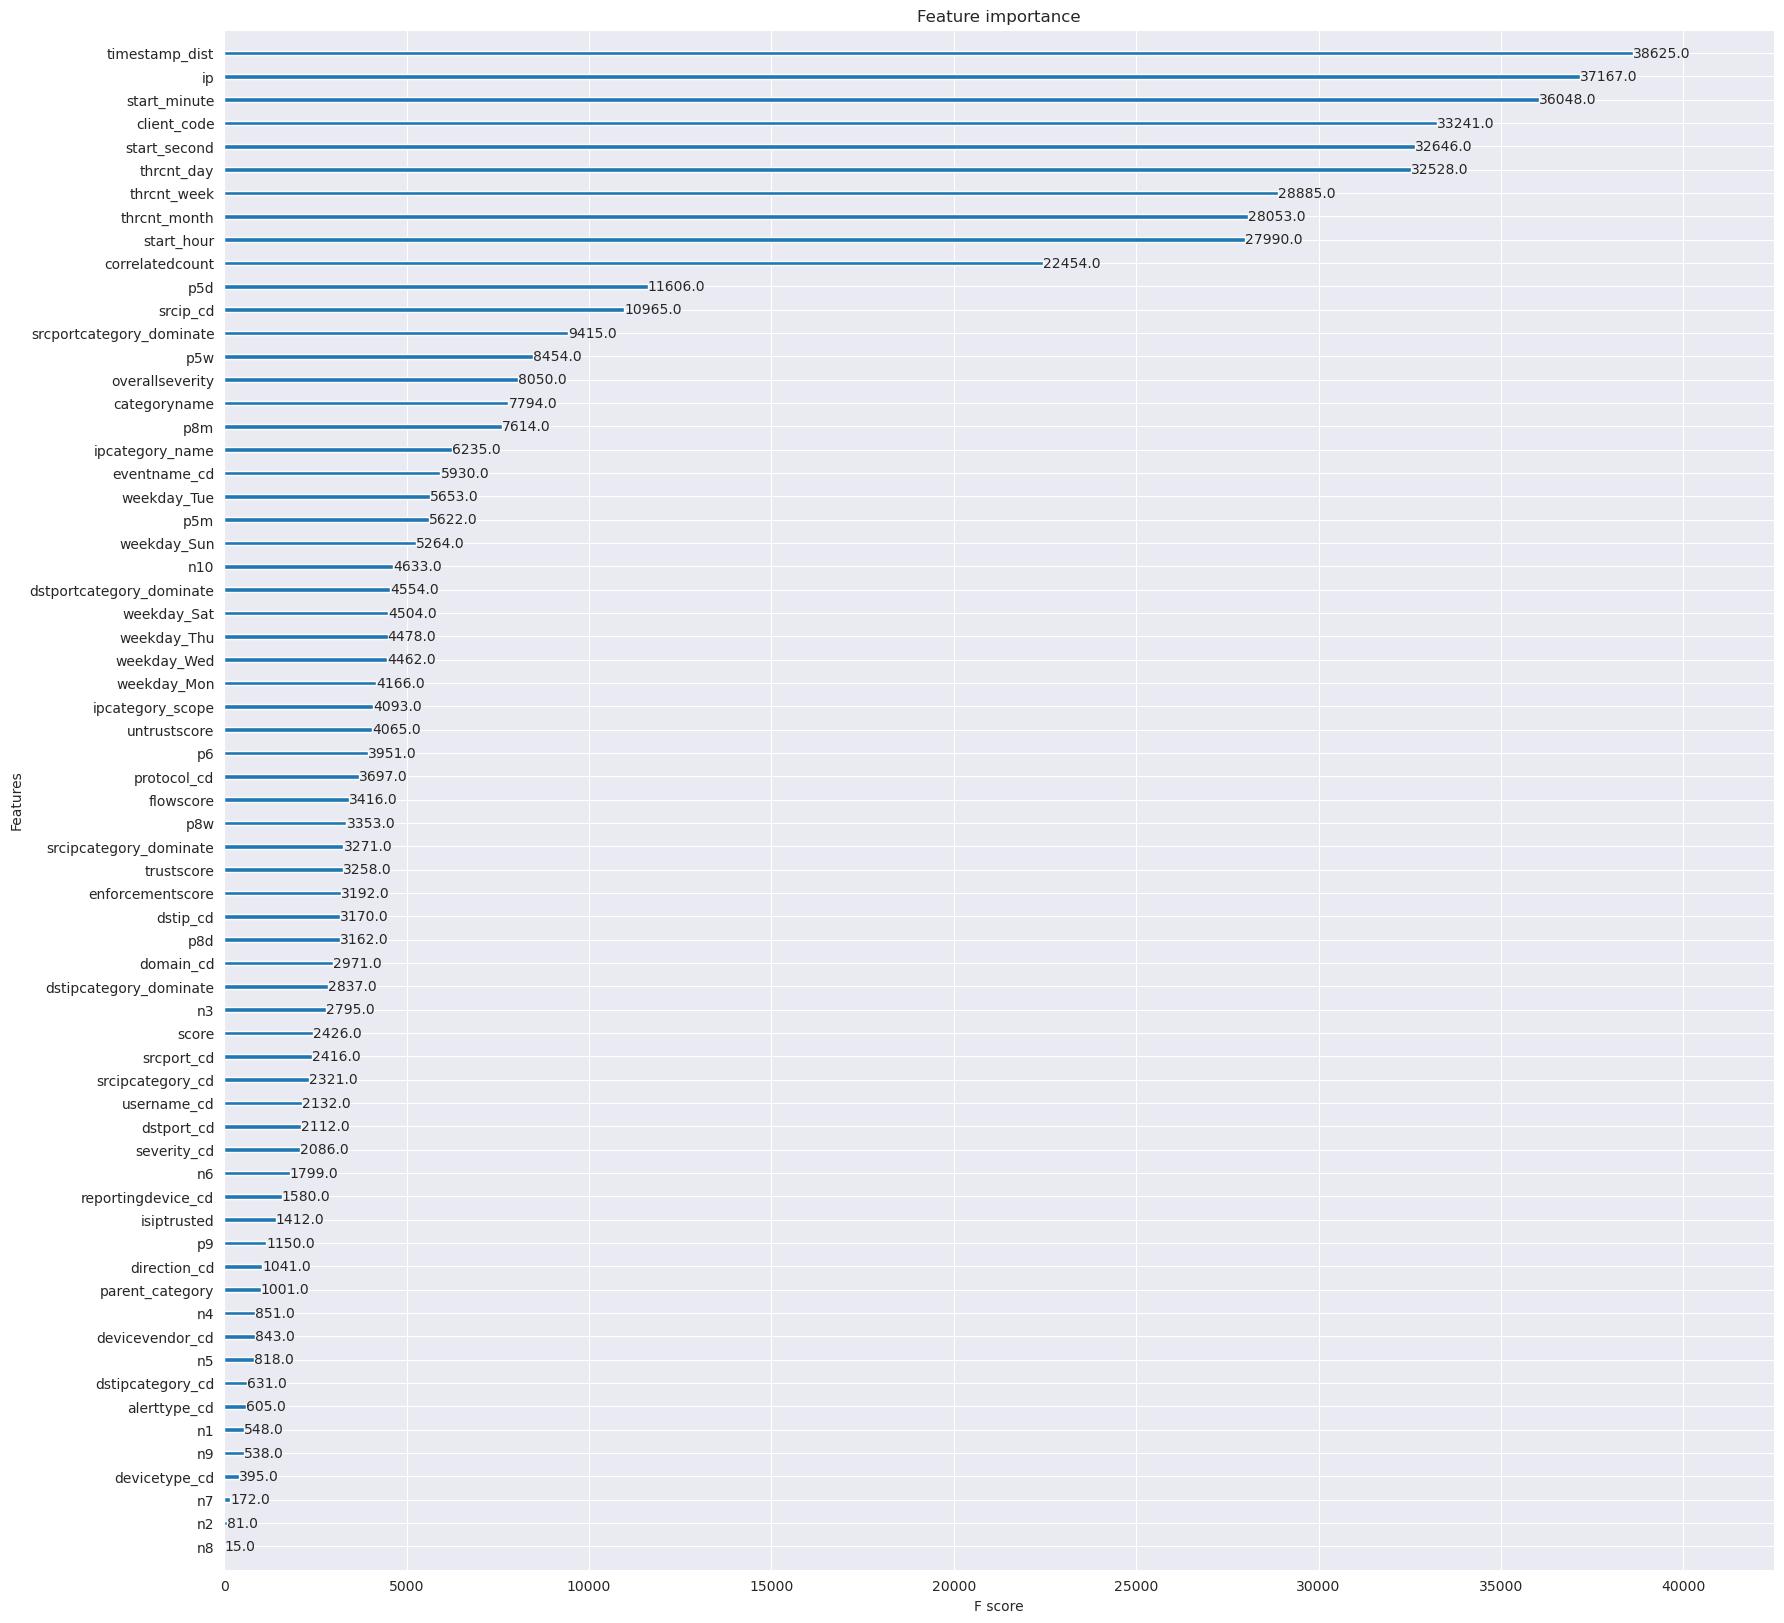

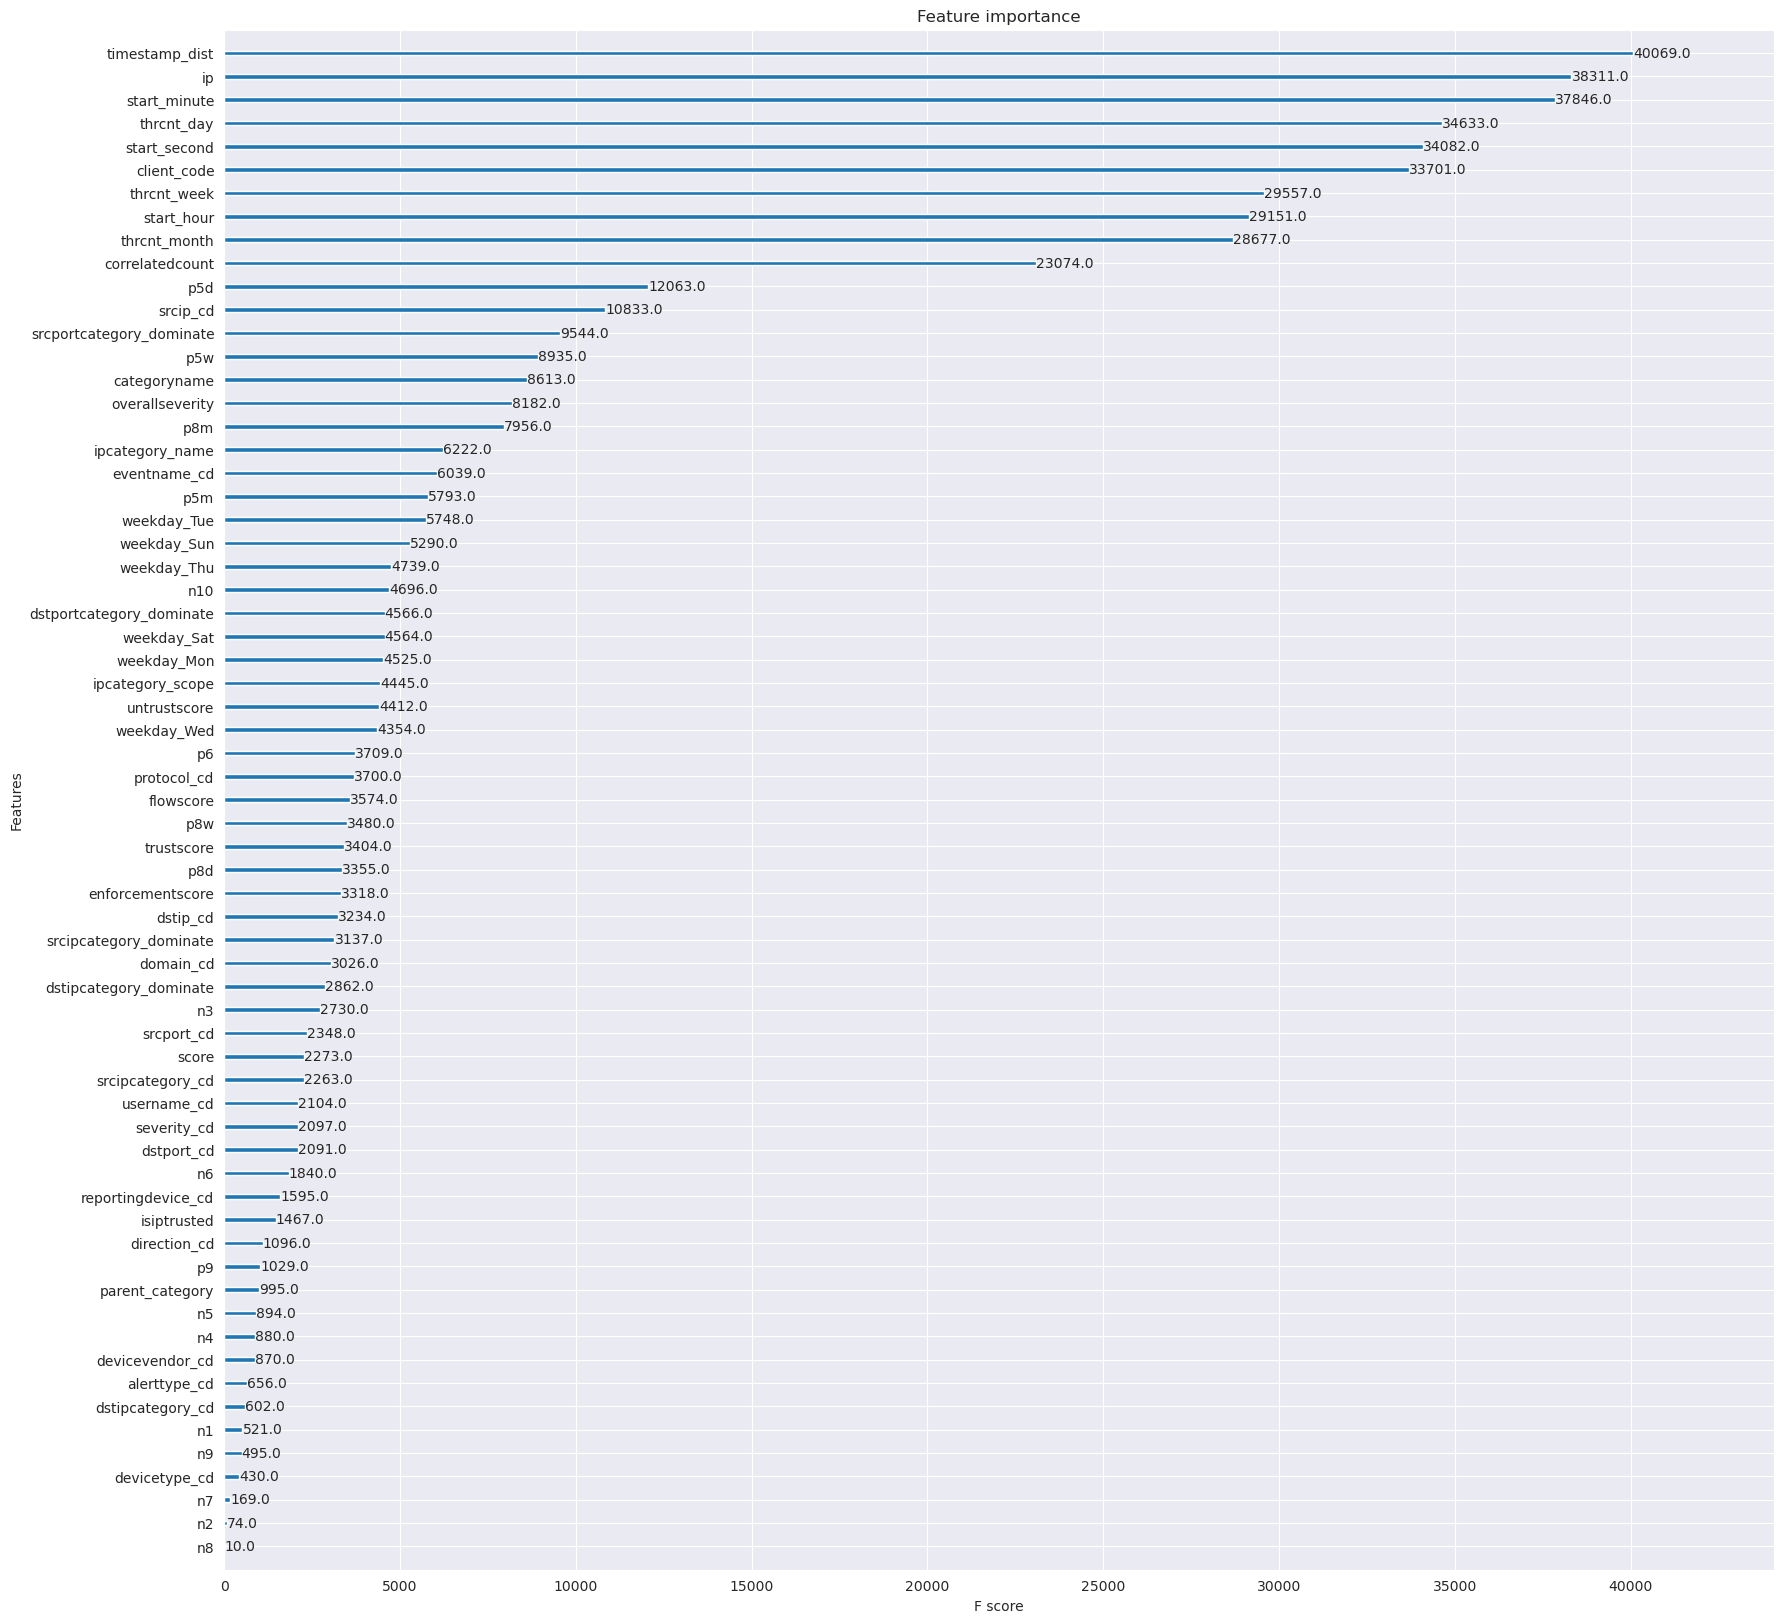

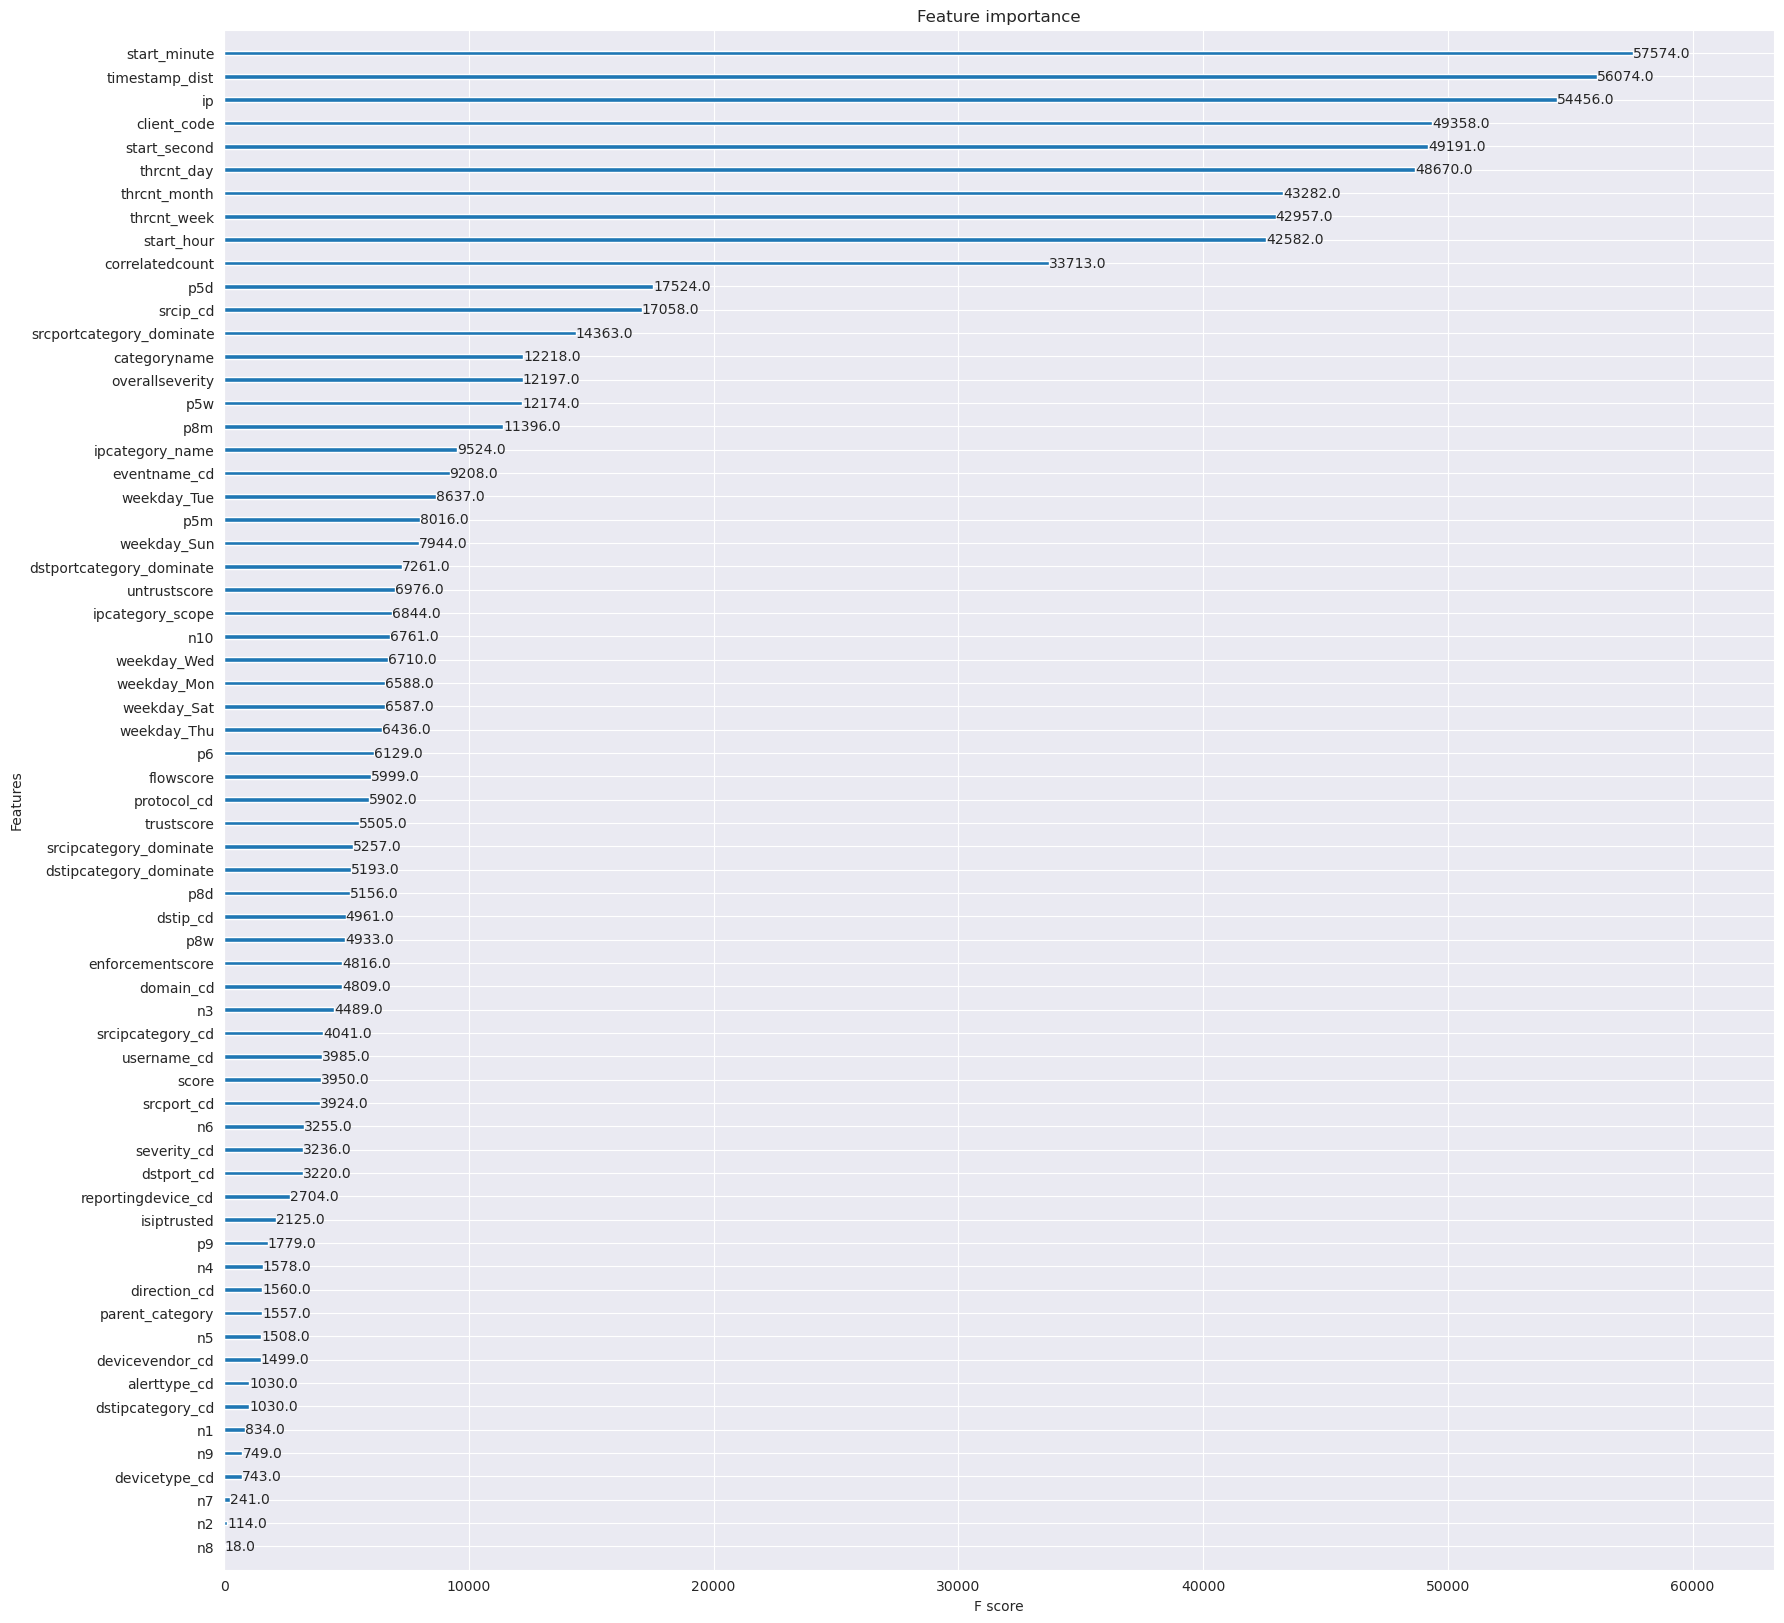

In [4]:
# Data preprocessing
preprocessed_train_df, preproc_test_df, features, _ =  preprocessing_data(df_train, df_test, target, features_for_preprocessing)
params = {
    'subsample': 0.9,
    'colsample_bytree': 0.5,
    'lambdax': 1,
    'max_depth':24,
    'early_stopping_rounds': 100,
    'eta': 0.025
}

trainResults, testResults, predictions, indices, hists = cv_xgb(preprocessed_train_df, target, features, debug=True, mlflow_tracking=True, exp_name='exp_4_feature_eng', **params)
print(f'Train mean: {np.mean(trainResults)}, Valid mean: {np.mean(testResults)}')

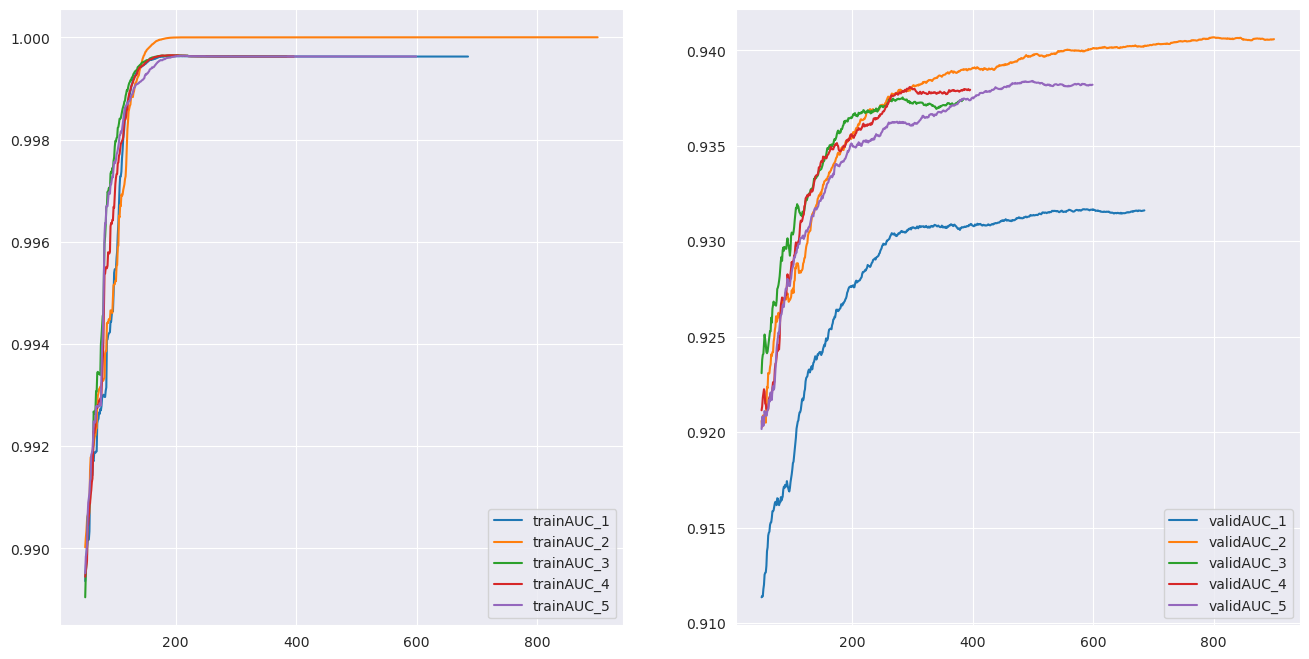

In [7]:
# Plot to compare results of each train and validation fold after using Cross Validation
fig, ax = plt.subplots(1, 2, figsize=(16,8))
for x in range(1, 6):
    hists[['trainAUC'+'_'+str(x)]].iloc[50:].plot(ax=ax[0])
    hists[['validAUC'+'_'+str(x)]].iloc[50:].plot(ax=ax[1])
plt.show()

In [12]:
# Save results to file
modelXGB= {
    "name":"XGB-4_FE",
    "description":"Model XGB, po preprocessingu",
    "specification": params,
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
    'features':features
}
save_model_and_results('model_xgb_4', modelXGB)

## Making prediction for competition

eta 0.025, max_depth 24, subsample 0.9, colsample_bytree 0.5, colsample_bylevel 1, lambdax 1, alpha 0, gamma 0, min_child_weight 0, num_boost_round 1000, early_stopping_rounds 30, rate_drop 0.2, skip_drop 0.5, eval_metric ['auc'], objective binary:logistic, seed None, booster gbtree, tree_method exact, grow_policy depthwise, 
Length train: 31541
Length valid: 7886
[0]	train-auc:0.87883	valid-auc:0.82255
[10]	train-auc:0.96458	valid-auc:0.88711
[20]	train-auc:0.97744	valid-auc:0.89213
[30]	train-auc:0.98380	valid-auc:0.90382
[40]	train-auc:0.98799	valid-auc:0.91215
[50]	train-auc:0.99050	valid-auc:0.91921
[60]	train-auc:0.99156	valid-auc:0.92170
[70]	train-auc:0.99240	valid-auc:0.92249
[80]	train-auc:0.99450	valid-auc:0.92492
[90]	train-auc:0.99578	valid-auc:0.92649
[100]	train-auc:0.99698	valid-auc:0.92812
[110]	train-auc:0.99804	valid-auc:0.93017
[120]	train-auc:0.99887	valid-auc:0.93168
[130]	train-auc:0.99909	valid-auc:0.93328
[140]	train-auc:0.99933	valid-auc:0.93325
[150]	train-au

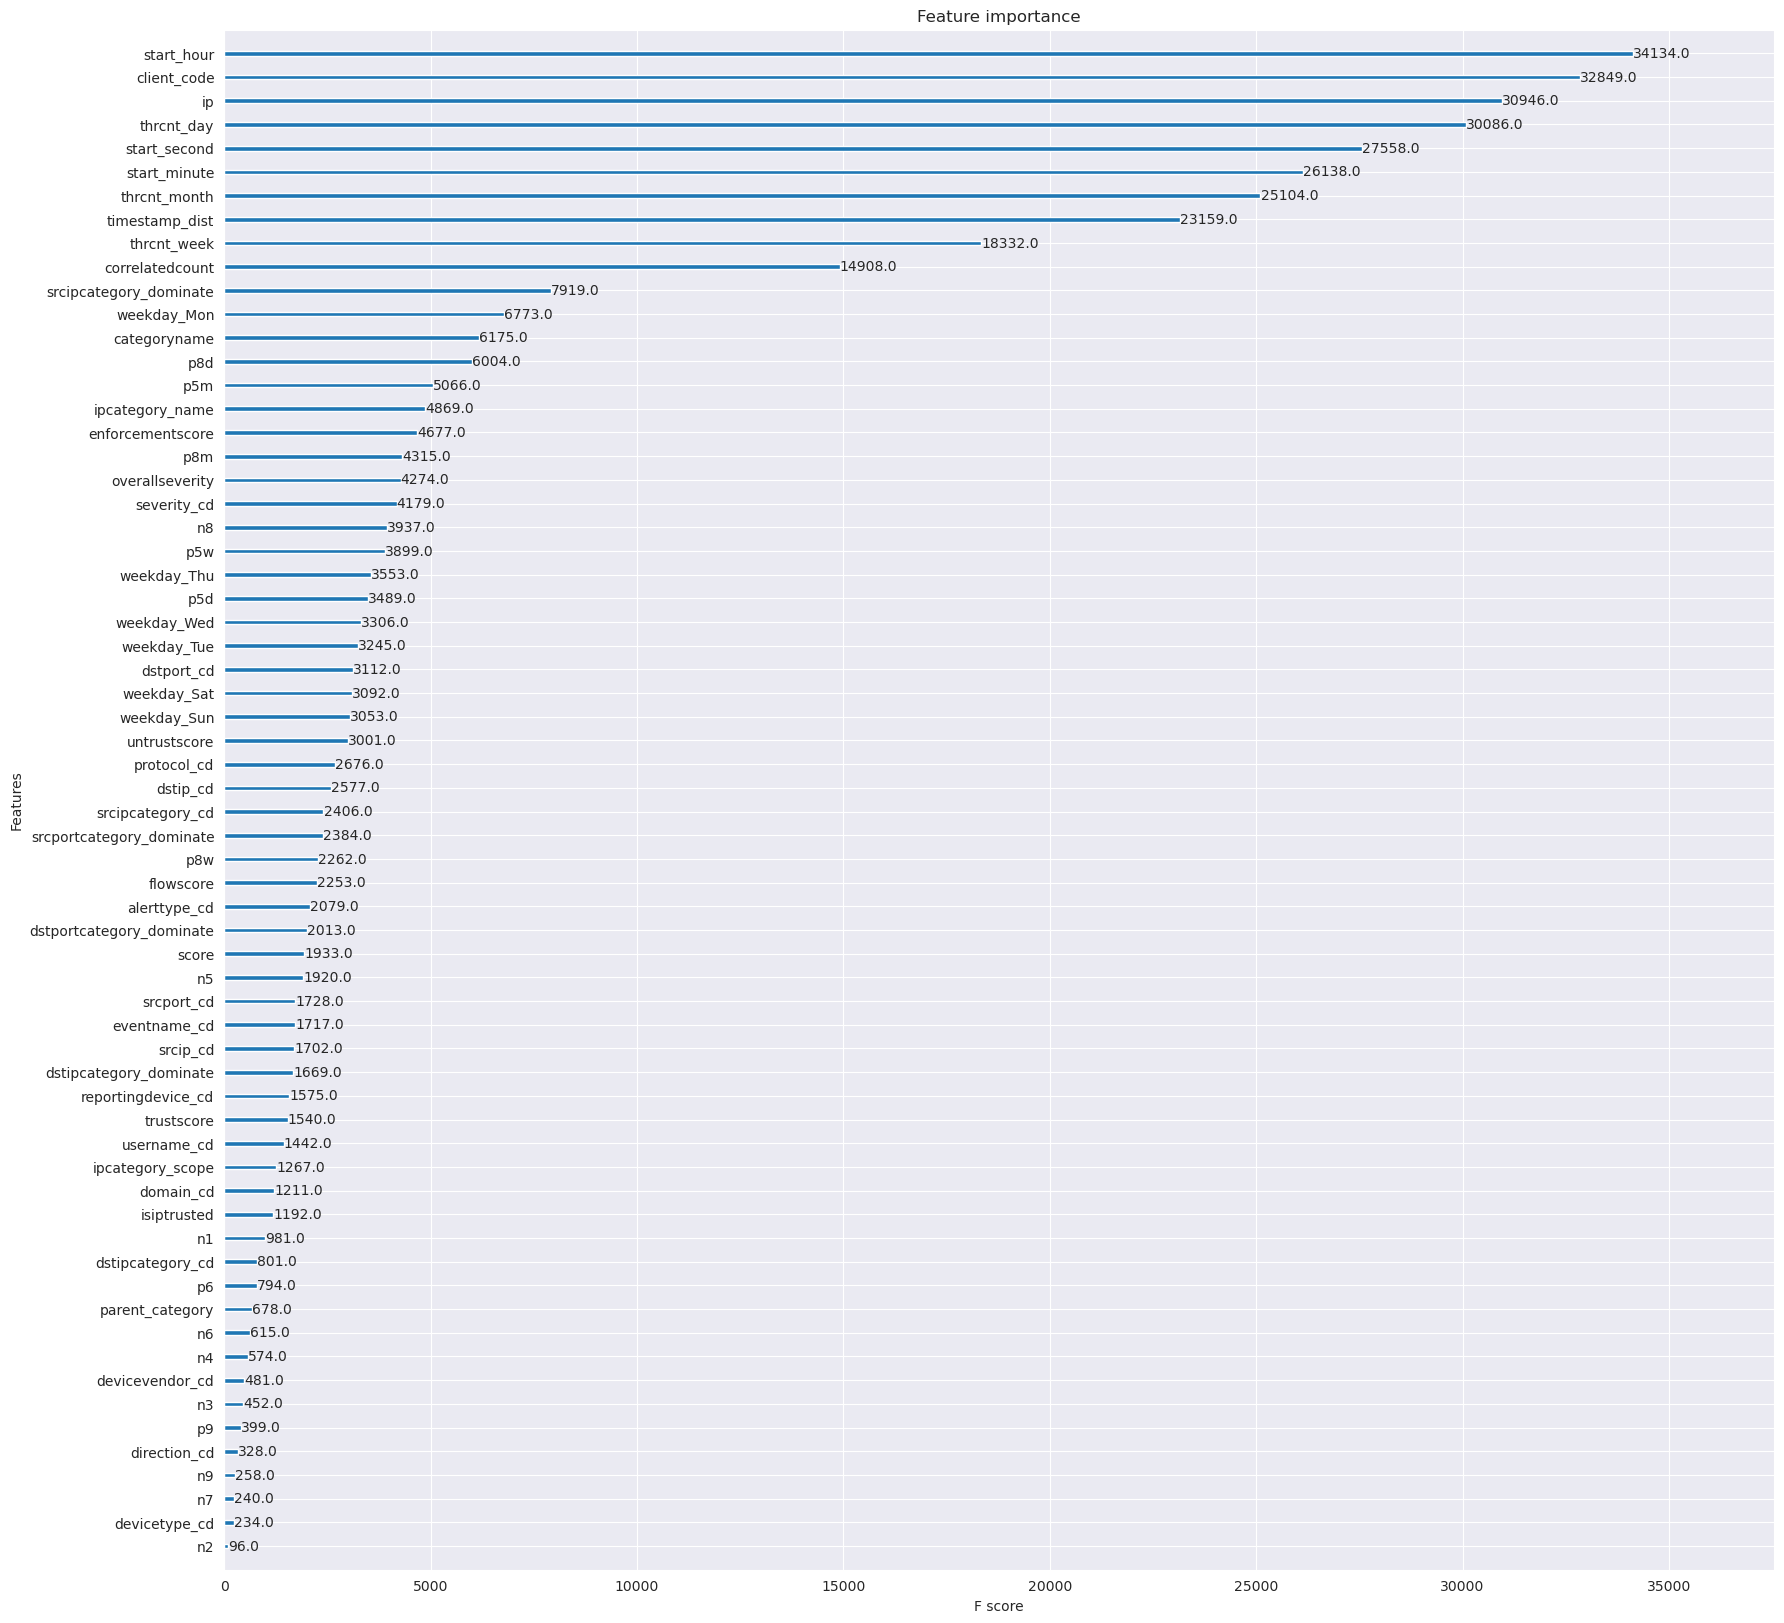

In [9]:
preprocessed_train_df, preprocessed_test_df, features, _ = preprocessing_data(df_train, df_test, target, features_for_preprocessing)
params = {
    'subsample': 0.9,
    'colsample_bytree': 0.5,
    'lambdax': 1,
    'max_depth':24,
    'early_stopping_rounds': 30,
    'eta': 0.025
}
make_prediction_xgb(train_df=preprocessed_train_df, test_df=preprocessed_test_df, features=features, target=target, random_state=None, file='results_7_xgb', **params)


## Comparing the results of different predictive models

In [12]:
# with open("output/models/model_RF_1.p", "rb") as fp:
#     model_RF_1 = pickle.load(fp)
#
# with open("output/models/model_RF_2.p", "rb") as fp:
#     model_RF_2 = pickle.load(fp)

with open("output/models/model_RF_3.p", "rb") as fp:
    model_RF_3 = pickle.load(fp)

with open("output/models/model_xgb_1.p", "rb") as fp:
    model_xgb_1 = pickle.load(fp)

# with open("output/models/model_xgb_2.p", "rb") as fp:
#     model_xgb_2 = pickle.load(fp)

with open("output/models/model_xgb_4.p", "rb") as fp:
    model_xgb_4 = pickle.load(fp)

39427
39427
39427


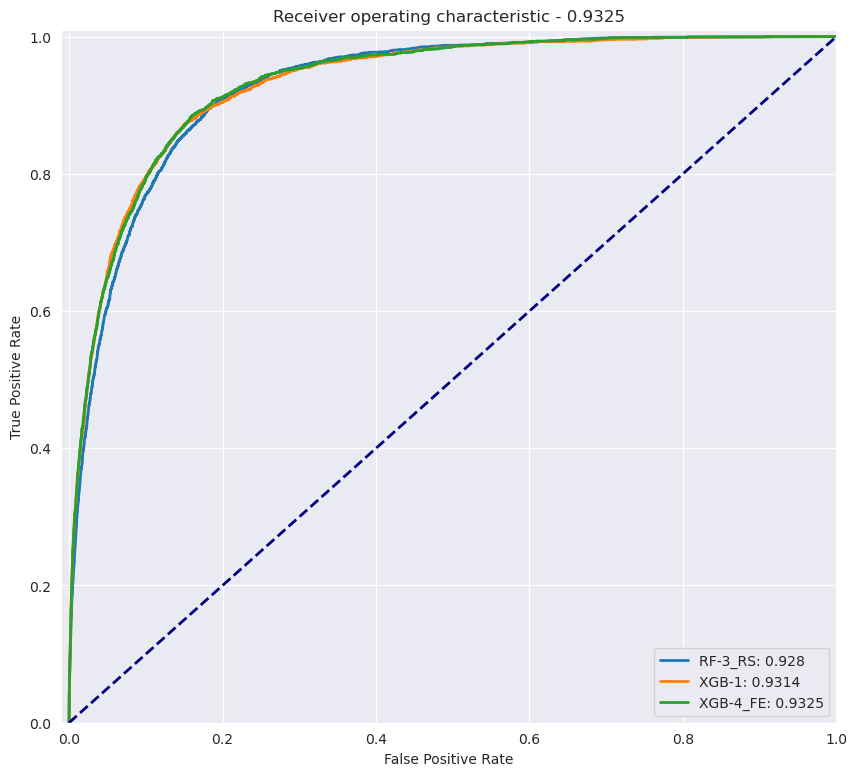

In [13]:
# Prepare data for the AUC-ROC curve
res2plot = []
true = preprocessed_train_df[target].sort_index()
for result in [model_RF_3, model_xgb_1, model_xgb_4]:
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    print(len(pred))
    res2plot.append((true, pred, result["name"]))

# Plot AUC-ROC curves
plot_roc_auc(res2plot)